In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

def _provide_date_info(data):

    data = data.copy()
    data['hour'] = data.date.dt.hour
    data['weekday'] = data.date.dt.weekday
    data['dom'] = data.date.dt.day
    data['week'] = data.date.dt.isocalendar().week
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['date_datetime'] = data.date.map(lambda x: x.to_pydatetime().date())
    data.drop(columns=['counter_name', 'site_name', 'counter_technical_id', 'counter_installation_date'], inplace=True)

    return data

def _clean_and_add_data(data):

    data = data.copy()
    data['origin_index'] = np.arange(data.shape[0])
    #file_path = Path(__file__).parent / 'external_data.csv'
    #external_data = pd.read_csv(file_path, parse_dates=['date'])
    external_data = pd.read_csv('external_data_covid_trot.csv', parse_dates=['date'])
    external_data_grouped = external_data.groupby(by=['date_datetime']).sum()
    counters_list = data.counter_id.unique()
    down_counters = external_data_grouped[counters_list] > 0
    days_down={}
    for counter in counters_list :
        string_list = down_counters[down_counters[counter] == True].index.values.tolist()
        date_datetime_list = [pd.to_datetime(j).date() for j in string_list]
        days_down[counter] = date_datetime_list

    data['is_down'] = data.apply(lambda x: x.date_datetime in days_down[x.counter_id], axis=1)
    data.drop(columns=['date_datetime'], inplace=True)

    external_data.cl = external_data.cl.fillna(value=100)
    external_data.cm = external_data.cm.fillna(value=100)
    external_data.ch = external_data.ch.fillna(value=100)
    external_data.drop(columns=counters_list, inplace=True)
    external_data.drop(columns=['numer_sta', 'per', 'pres', 'nnuage1', 'ctype1', 'hnuage1', 'pmer', 'tend', 
                                'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'hbas', 'nbas', 'n',
                                'tend24', 'ssfrai', 'niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
                                'sw', 'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage2', 'ctype2', 'hnuage2',
                                'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4',
                                'perssfrai', 'etat_sol'], inplace=True)
    external_data.fillna(method='ffill', inplace=True)
    ext_index = external_data.set_index('date')
    ext_index.sort_index(inplace=True)
    ext_index.drop_duplicates(inplace=True)
    data_index = data.set_index('date')
    data_index.sort_index(inplace=True)
    merged_data = pd.merge_asof(data_index, ext_index, left_index=True, right_index=True)
    merged_data.sort_values("origin_index", inplace=True)
    merged_data.drop(columns=['origin_index'], inplace=True)
    merged_data['is_confinement_1'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-12-15')
    merged_data['commerce_fermes_20'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-11-28')
    merged_data['couvre_feu_20'] = (merged_data.date_datetime > '2020-12-14') & (merged_data.date_datetime < '2021-01-17')
    merged_data['couvre_feu_18'] = ((merged_data.date_datetime > '2021-01-16') & (merged_data.date_datetime < '2021-03-20')) | ((merged_data.date_datetime > '2021-05-02') & (merged_data.date_datetime < '2021-05-19'))
    merged_data['is_confinement_2'] = (merged_data.date_datetime > '2021-03-19') & (merged_data.date_datetime < '2021-04-03')
    merged_data['is_confinement_3'] = (merged_data.date_datetime > '2021-04-02') & (merged_data.date_datetime < '2021-05-03')
    merged_data['couvre_feu_21'] = (merged_data.date_datetime > '2021-18-05') & (merged_data.date_datetime < '2021-09-06')
    merged_data['couvre_feu_23'] = (merged_data.date_datetime > '2021-08-06') & (merged_data.date_datetime < '2021-21-06')
    merged_data.drop(columns=['date_datetime'], inplace=True)

    return merged_data

# def get_estimator():

provide_date_info = FunctionTransformer(_provide_date_info)
clean_and_add_data = FunctionTransformer (_clean_and_add_data)

passthrough = ['is_ferie', 'is_holiday', 'is_confinement_1', 'is_confinement_2', 'commerce_fermes_20',
                            'couvre_feu_20', 'couvre_feu_18', 'is_confinement_3', 'couvre_feu_21', 'couvre_feu_23', 'weekday',
                             'is_daylight', 'cl', 'cm', 'ch', 'pluie_intermittente', 'pluie_continue', 'pluie_forte',
                             'pluie_faible', 'pluie_modérée', 'neige', 'bruine', 'brouillard', 'verglas', 'is_down']
numerical_columns = ['hour',
                        'month',
                        'latitude',
                        'longitude',
                        'dom',
                        'week',
                        'Res.',
                        'Vit.',
                        'Raf.3',
                        'Hum. [%]',
                        'Visi. [Km]',
                        'pluie_direct',
                        'pluie_last_3',
                        'temps_soleil',
                        'pluie_cumul_day',
                        'vent_max',
                        'raf10',
                        'rafper',
                        'ht_neige',
                        'rr1',
                        'rr3',
                        'rr6',
                        'rr12',
                        'rr24',
                        'covid_last7',
                        'nb_trot']


preprocessor = ColumnTransformer([('standard_scaler', StandardScaler(), numerical_columns), ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100), ['counter_id', 'site_id', 'year']), ('pass', 'passthrough', passthrough)])

    #model = HistGradientBoostingRegressor(max_depth=20, min_samples_leaf=50, l2_regularization=10, max_iter=500, categorical_features=list(range(25, 52)))

    #pipe = make_pipeline(provide_date_info, clean_and_add_data, preprocessor, model)

    # return pipe

In [2]:
X = pd.read_parquet(Path('data') / 'train.parquet')

In [3]:
X_1 = provide_date_info.fit_transform(X.drop(['bike_count'], axis=1))

In [4]:
X_2 = clean_and_add_data.fit_transform(X_1)

In [5]:
X_2.head()

,counter_id,site_id,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,...,is_ferie,is_holiday,is_confinement_1,commerce_fermes_20,couvre_feu_20,couvre_feu_18,is_confinement_2,is_confinement_3,couvre_feu_21,couvre_feu_23
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,100007049-102007049,100007049,48.846028,2.375429,0.000000,2,1,1,36,9,...,False,False,False,False,False,False,False,False,False,False
2020-09-01 03:00:00,100007049-102007049,100007049,48.846028,2.375429,0.693147,3,1,1,36,9,...,False,False,False,False,False,False,False,False,False,False
2020-09-01 04:00:00,100007049-102007049,100007049,48.846028,2.375429,0.000000,4,1,1,36,9,...,False,False,False,False,False,False,False,False,False,False
2020-09-01 15:00:00,100007049-102007049,100007049,48.846028,2.375429,1.609438,15,1,1,36,9,...,False,False,False,False,False,False,False,False,False,False
2020-09-01 18:00:00,100007049-102007049,100007049,48.846028,2.375429,2.302585,18,1,1,36,9,...,False,False,False,False,False,False,False,False,False,False


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
corr = X_2.corr()

In [8]:
corr_bike_count = corr['log_bike_count']

In [9]:
print(corr_bike_count)

site_id                0.018890
latitude               0.108289
longitude              0.044736
log_bike_count         1.000000
hour                   0.268903
weekday               -0.056949
dom                   -0.012793
week                   0.030824
month                  0.048162
year                  -0.019968
is_down               -0.195803
Res.                   0.301188
Vit.                   0.074327
Raf.3                  0.102277
Hum. [%]              -0.305015
Visi. [Km]             0.125945
pluie_direct          -0.026616
pluie_last_3          -0.024292
pluie_intermittente   -0.007500
pluie_continue        -0.066665
pluie_forte           -0.015804
pluie_faible          -0.058775
pluie_modérée         -0.030289
neige                 -0.024090
bruine                -0.029138
brouillard            -0.017720
verglas               -0.018186
is_daylight            0.567361
temps_soleil           0.104554
pluie_cumul_day       -0.040129
vent_max              -0.048474
cl      

In [10]:
len(corr_bike_count)

52

In [11]:
len(passthrough)

25

In [12]:
len(numerical_columns)

24

<AxesSubplot:>

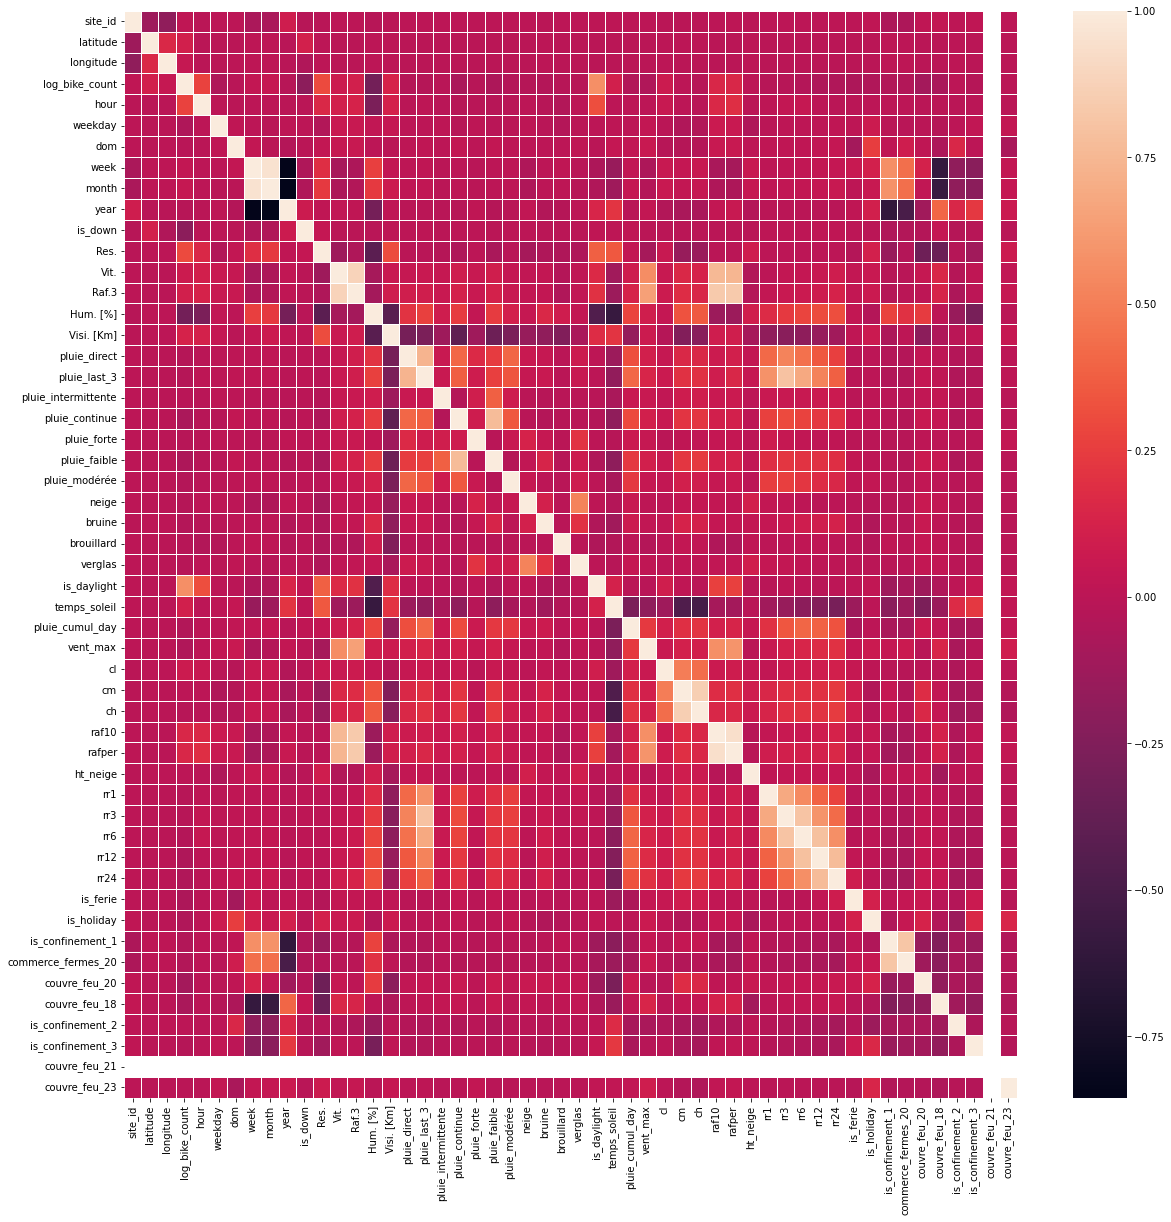

In [13]:
plt.figure(figsize = (20,20))
sns.heatmap(corr, linewidths=1)

### Beaucoup de variables semblent inutiles ou redondantes => garder seulement une des variables pluie, raf et rr ?


array([[<AxesSubplot:title={'center':'site_id'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'log_bike_count'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'weekday'}>],
       [<AxesSubplot:title={'center':'dom'}>,
        <AxesSubplot:title={'center':'week'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'Res.'}>,
        <AxesSubplot:title={'center':'Vit.'}>],
       [<AxesSubplot:title={'center':'Raf.3'}>,
        <AxesSubplot:title={'center':'Hum. [%]'}>,
        <AxesSubplot:title={'center':'Visi. [Km]'}>,
        <AxesSubplot:title={'center':'pluie_direct'}>,
        <AxesSubplot:title={'center':'pluie_last_3'}>,
        <AxesSubplot:title={'center':'temps_soleil'}>],
       [<AxesSubplot:title={'center':'pluie_cumul_day'}>,
        <AxesSubplot:title={'cent

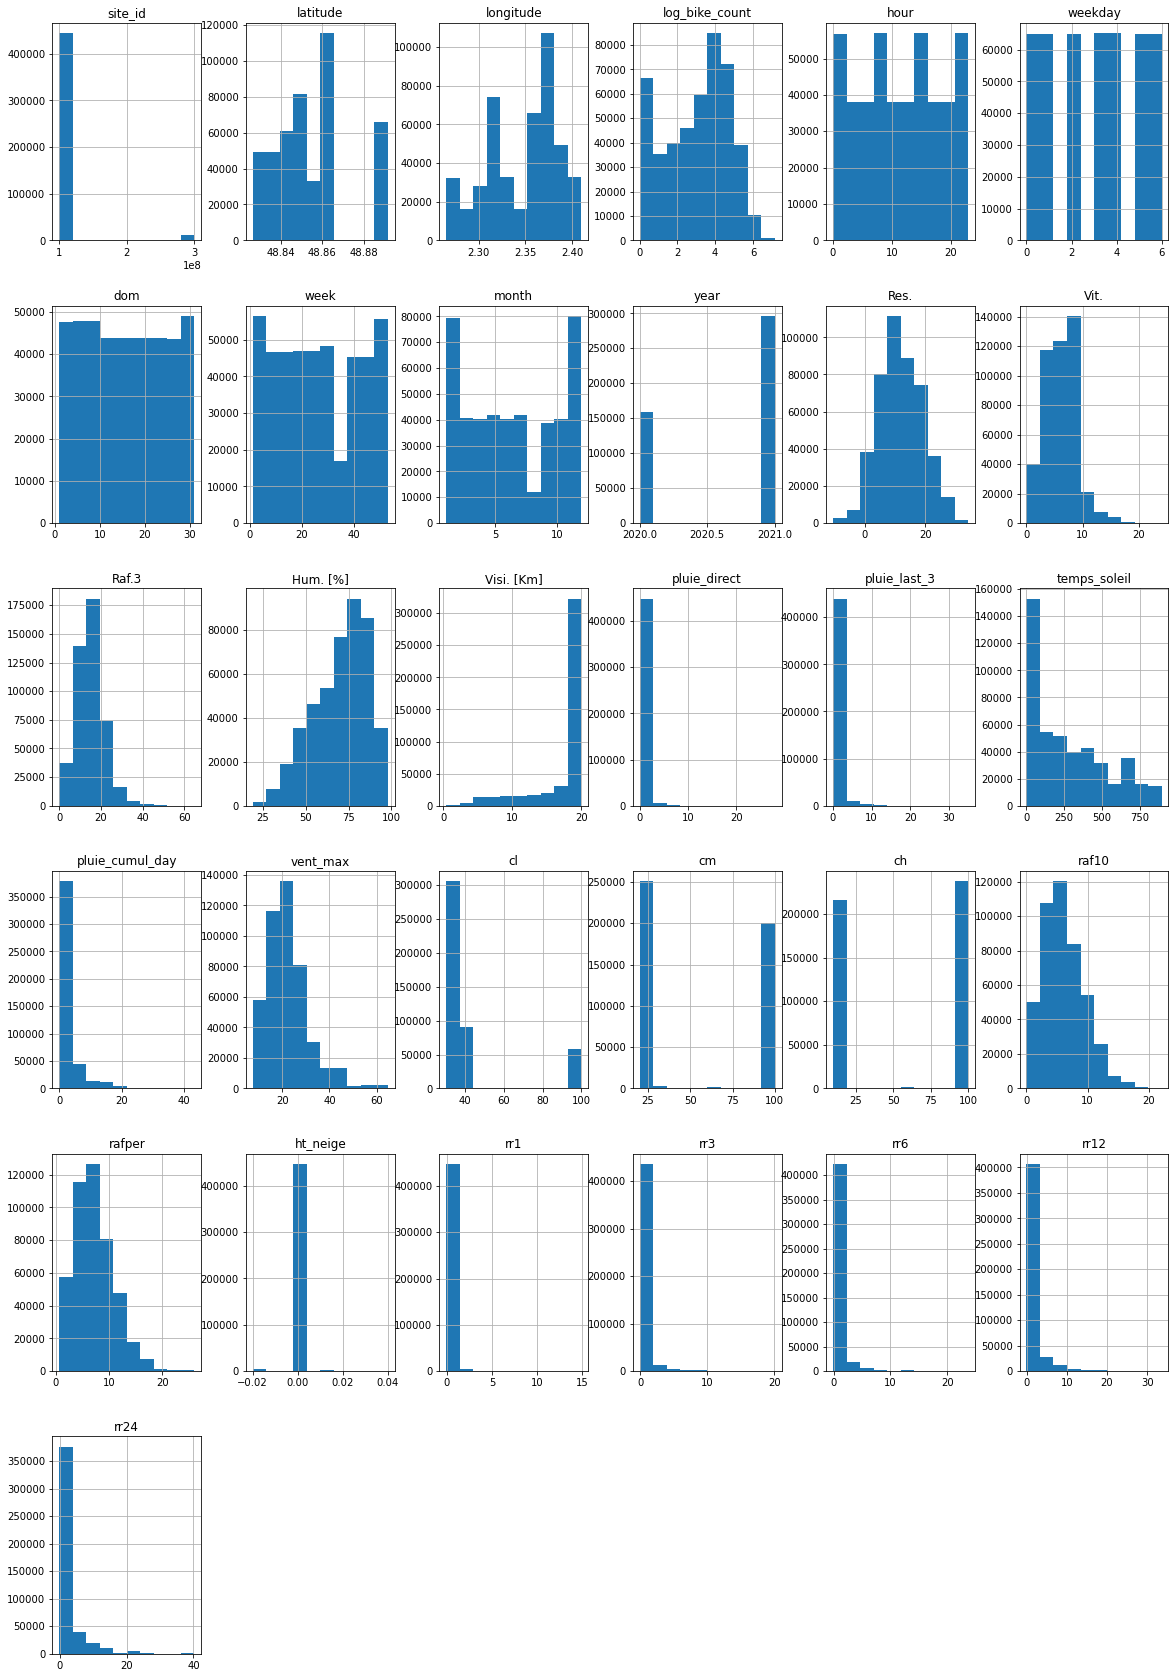

In [14]:
X_2.hist(figsize=(20, 30))

### Il semblerait pertinent de prendre le log des variables pluie, rr et rafper

In [15]:
test = X_2['rr12']+1

In [16]:
test_log = test.apply(np.log)

In [17]:
test_log

date
2020-09-01 02:00:00    0.000000
2020-09-01 03:00:00    0.000000
2020-09-01 04:00:00    0.000000
2020-09-01 15:00:00    0.000000
2020-09-01 18:00:00    0.000000
                         ...   
2021-08-08 18:00:00    0.182322
2021-08-09 02:00:00    0.000000
2021-08-09 08:00:00    0.000000
2021-08-09 10:00:00   -0.105361
2021-08-09 17:00:00   -0.105361
Name: rr12, Length: 455163, dtype: float64

<AxesSubplot:>

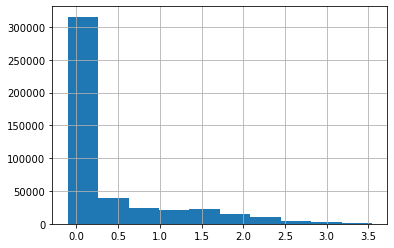

In [18]:
test_log.hist()

In [41]:
sns.pairplot(X_2)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001B30E496430> (for post_execute):


KeyboardInterrupt: 

## Impossible de faire un pairplot -> trop de variables et de data

# Etude impact confinement

<AxesSubplot:xlabel='is_confinement_1', ylabel='log_bike_count'>

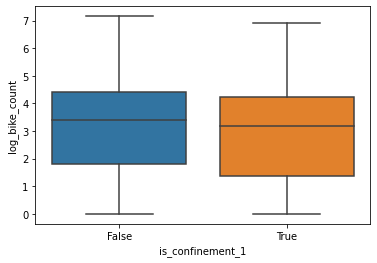

In [20]:
sns.boxplot(x= X_2['is_confinement_1'], y=X_2['log_bike_count'])

<AxesSubplot:xlabel='is_confinement_2', ylabel='log_bike_count'>

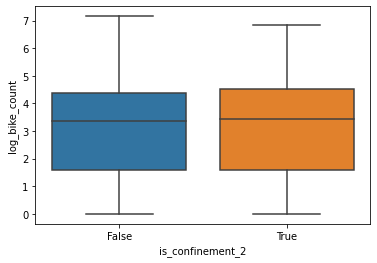

In [21]:
sns.boxplot(x= X_2['is_confinement_2'], y=X_2['log_bike_count'])

<AxesSubplot:xlabel='is_confinement_3', ylabel='log_bike_count'>

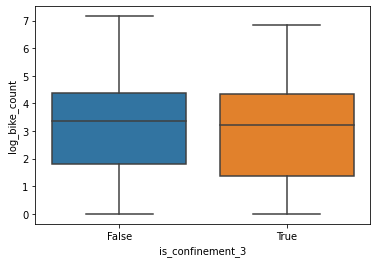

In [22]:
sns.boxplot(x= X_2['is_confinement_3'], y=X_2['log_bike_count'])

## On s'attendrait effectivement à voir que le min et le max soient à peu près du même ordre de grandeur. Mais l'absence de diff sur la médiane est curieuse.

In [40]:
lockdown_1_impact = pd.DataFrame(X_2[['log_bike_count', 'is_confinement_1','hour']].groupby(['hour','is_confinement_1']).mean())
print(lockdown_1_impact)

                       log_bike_count
hour is_confinement_1                
0    False                   1.158553
     True                    0.859656
1    False                   0.888122
     True                    0.630105
2    False                   0.815487
     True                    0.544294
3    False                   1.143972
     True                    0.703493
4    False                   1.842501
     True                    1.408001
5    False                   2.778576
     True                    2.247657
6    False                   3.754985
     True                    3.320746
7    False                   4.148614
     True                    4.110433
8    False                   3.913881
     True                    4.049110
9    False                   3.782229
     True                    3.718621
10   False                   3.945299
     True                    3.744730
11   False                   4.015825
     True                    3.933929
12   False  

## On observe que le confinement a un effet beaucoup plus net lors des horaires extrêmes (avant 7h et après 19h)

## Feature importance analysis

In [50]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [52]:
model = HistGradientBoostingRegressor(max_depth=20, min_samples_leaf=50, l2_regularization=10, max_iter=500, categorical_features=list(range(25, 52)))

In [57]:
X_temp, y_temp = preprocessor.fit_transform(X_2.drop(['log_bike_count'], axis=1)), X_2['log_bike_count']

In [58]:
X_temp.shape

(455163, 52)

In [59]:
X_temp

array([[-1.373101487345414, 0.7365810600695957, -0.4487984496821534, ...,
        False, False, False],
       [-1.2286098172510296, 0.7365810600695957, -0.4487984496821534,
        ..., False, False, False],
       [-1.0841181471566452, 0.7365810600695957, -0.4487984496821534,
        ..., False, False, False],
       ...,
       [-0.5061514667791077, 0.4534730394481804, -0.7859945769183397,
        ..., False, False, False],
       [-0.217168126590339, 0.4534730394481804, -0.7859945769183397, ...,
        False, False, False],
       [0.7942735640703515, 0.4534730394481804, -0.7859945769183397, ...,
        False, False, False]], dtype=object)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2)

In [64]:
model.fit(X_train, y_train)

HistGradientBoostingRegressor(categorical_features=[25, 26, 27, 28, 29, 30, 31,
                                                    32, 33, 34, 35, 36, 37, 38,
                                                    39, 40, 41, 42, 43, 44, 45,
                                                    46, 47, 48, 49, 50, 51],
                              l2_regularization=10, max_depth=20, max_iter=500,
                              min_samples_leaf=50)

In [66]:
preds = model.predict(X_test)

In [68]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(preds, y_test, squared=False)
mse

0.3864615272036946

In [132]:
from sklearn.inspection import permutation_importance
features_imp = permutation_importance(model, X_test, y_test, scoring= 'neg_root_mean_squared_error')

In [133]:
features_imp

{'importances_mean': array([1.48688952e+00, 3.77027293e-02, 2.83475334e-02, 1.51398941e-02,
        1.12722687e-02, 1.27354668e-01, 8.71530589e-02, 4.67248502e-04,
        9.91511805e-04, 1.15481227e-02, 1.48601323e-03, 2.61292945e-03,
        1.78758272e-03, 5.87396051e-03, 5.85526457e-03, 3.89765702e-03,
        3.90825898e-03, 3.50681316e-03, 1.21370219e-03, 4.77641286e-04,
        5.78700916e-04, 6.51263414e-04, 8.56710543e-04, 3.87630866e-03,
        1.87270068e-01, 7.02446170e-01, 3.95825390e-03, 1.22473376e-02,
        1.59015753e-02, 6.36429527e-04, 5.51098791e-04, 1.64803449e-02,
        8.69662602e-04, 1.41682179e-03, 2.14706846e-02, 0.00000000e+00,
        1.90590572e-04, 2.28658374e-01, 3.38518836e-02, 2.93929938e-03,
        6.12306083e-04, 1.30964795e-03, 2.53166682e-04, 4.69330014e-04,
        1.78536896e-04, 3.05230895e-05, 1.72049323e-04, 8.71877520e-07,
        6.17690155e-04, 0.00000000e+00, 0.00000000e+00, 1.86511413e-01]),
 'importances_std': array([4.02040960e-03,

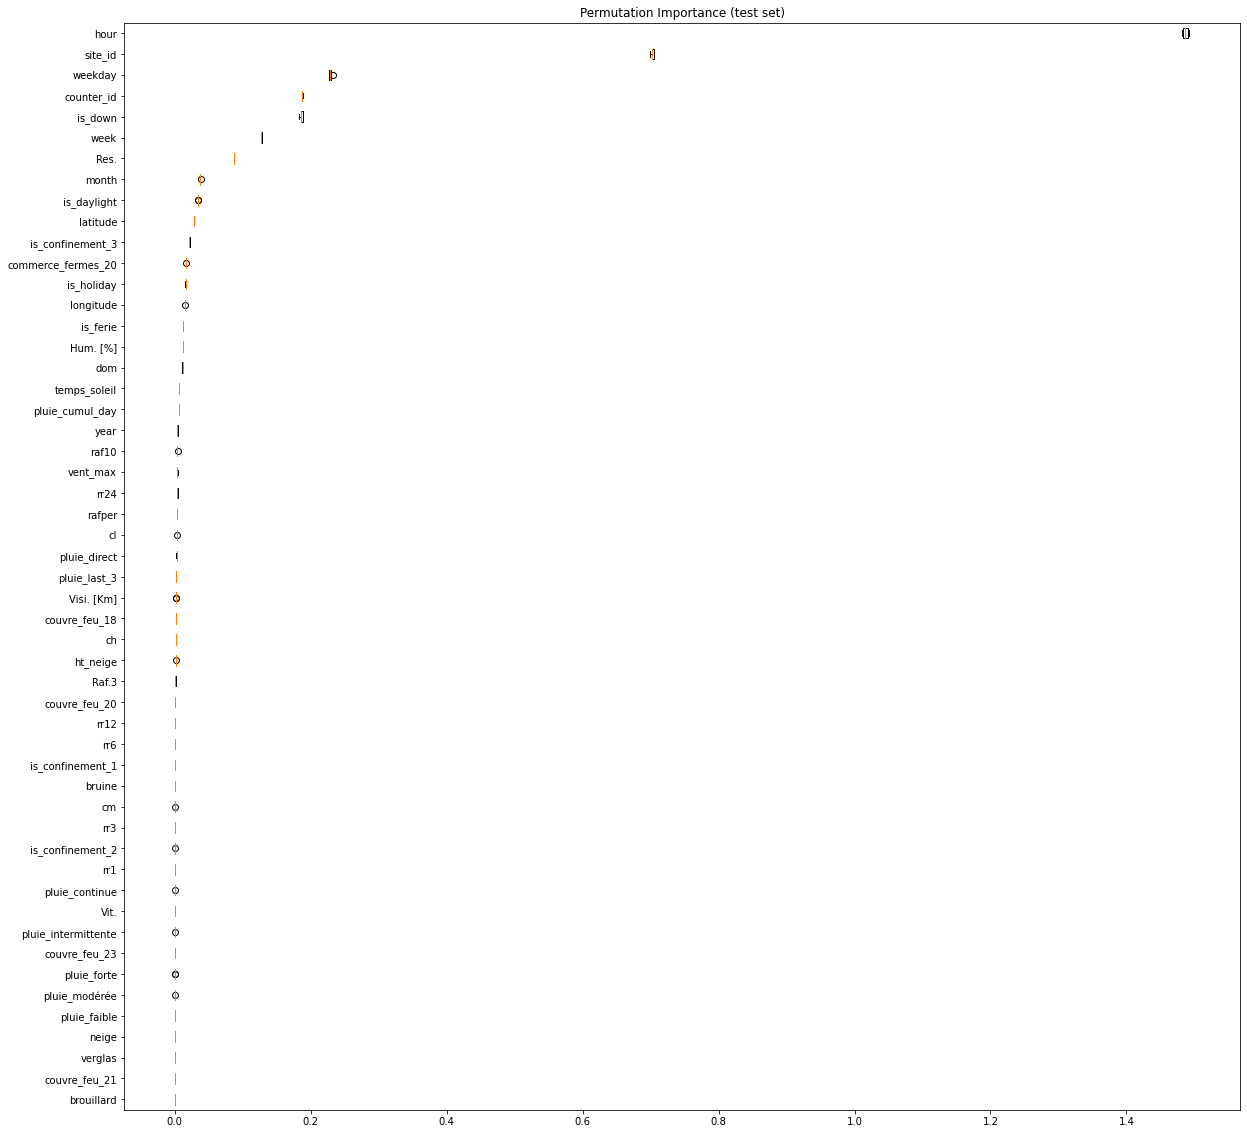

In [134]:
sorted_idx = features_imp.importances_mean.argsort()
features = numerical_columns + ['counter_id', 'site_id', 'year']+  passthrough
plt.figure(figsize = (20,20))
plt.boxplot(
    features_imp.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [106]:
model.n_features_in_

52

In [103]:
len(features)

49

In [107]:
dir(model)

['_VALID_LOSSES',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_baseline_prediction',
 '_bin_data',
 '_bin_mapper',
 '_check_categories',
 '_check_early_stopping_loss',
 '_check_early_stopping_scorer',
 '_check_n_features',
 '_clear_state',
 '_compute_partial_dependence_recursion',
 '_encode_y',
 '_estimator_type',
 '_get_loss',
 '_get_param_names',
 '_get_small_trainset',
 '_get_tags',
 '_is_fitted',
 '_loss',
 '_more_tags',
 '_n_features',
 '_predict_iterations',
 '_predictors',
 '_print_iteration_stats',
 '_random_seed',
 '_raw_predict',
 '_repr_html_',
 '_repr_html_inner',
 '_

In [112]:
model.is_categorical_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [114]:
len(features_imp.importances_mean)

52

In [115]:
len(passthrough)

25

In [116]:
len(numerical_columns)

24